# Phase 4.2: Advanced Model Development

This notebook implements advanced machine learning models (XGBoost, LightGBM) with hyperparameter optimization and comprehensive evaluation.

## Objectives
1. Load baseline model results for comparison
2. Train XGBoost and LightGBM models
3. Perform hyperparameter optimization using Optuna
4. Compare all models with comprehensive metrics
5. Implement SHAP analysis for interpretability
6. Select best performing model for production

In [1]:
import sys
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Add src to path for imports
sys.path.append("../src")

from models.ensemble_models import (
    EnsembleModelOptimizer,
    LightGBMChurnModel,
    ModelComparison,
    XGBoostChurnModel,
    analyze_model_with_shap,
)

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

print("Phase 4.2: Advanced Model Development")
print("=" * 40)
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Phase 4.2: Advanced Model Development
Analysis date: 2025-08-16 08:18:24


## 1. Load Data and Prepare for Advanced Modeling

In [2]:
# Load the processed feature data from Phase 3
print("Loading processed features...")
try:
    dataset = pd.read_csv("../data/processed/features_selected.csv")
    print(f"Loaded dataset with {len(dataset)} users and {len(dataset.columns)} columns")

    # Display basic info
    print(f"  Churn rate: {dataset['is_churned'].mean():.1%}")
    print(f"  Features available: {len(dataset.columns) - 2}")  # Subtract userId and is_churned

except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Prepare features and target
feature_cols = [col for col in dataset.columns if col not in ["userId", "is_churned"]]
X = dataset[feature_cols].copy()
y = dataset["is_churned"].copy()

# Handle any missing values
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution: {dict(y.value_counts())}")

Loading processed features...
Loaded dataset with 226 users and 55 columns
  Churn rate: 47.3%
  Features available: 53

Feature matrix shape: (226, 53)
Target distribution: {False: np.int64(119), True: np.int64(107)}


In [3]:
# Create train/val/test splits (same as baseline for fair comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print("Data splits:")
print(f"  Training: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"  Validation: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
print(f"  Test: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

print("\nChurn rates by split:")
print(f"  Training: {y_train.mean():.1%}")
print(f"  Validation: {y_val.mean():.1%}")
print(f"  Test: {y_test.mean():.1%}")

Data splits:
  Training: 135 samples (59.7%)
  Validation: 45 samples (19.9%)
  Test: 46 samples (20.4%)

Churn rates by split:
  Training: 47.4%
  Validation: 46.7%
  Test: 47.8%


## 2. Baseline Model Results (for Comparison)

In [4]:
# Train baseline model for comparison
print("Training baseline logistic regression model...")

# Since our dataset doesn't have temporal data suitable for the baseline model's
# temporal splitting, we'll create a simple logistic regression baseline directly
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train simple logistic regression
start_time = time.time()
baseline_lr = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
baseline_lr.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Evaluate on test set
y_test_pred_proba = baseline_lr.predict_proba(X_test_scaled)[:, 1]
y_test_pred = baseline_lr.predict(X_test_scaled)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

# Create baseline_results in the expected format
baseline_results = {
    "test_metrics": {
        "auc_roc": test_auc,
        "f1_score": test_report["weighted avg"]["f1-score"],
        "precision": test_report["weighted avg"]["precision"],
        "recall": test_report["weighted avg"]["recall"]
    },
    "training_history": {
        "training_time_seconds": training_time
    }
}

print("Baseline model trained")
print(f"  Test AUC-ROC: {baseline_results['test_metrics']['auc_roc']:.4f}")
print(f"  Test F1: {baseline_results['test_metrics']['f1_score']:.4f}")
print(f"  Training time: {baseline_results['training_history']['training_time_seconds']:.2f}s")

Training baseline logistic regression model...
Baseline model trained
  Test AUC-ROC: 0.9981
  Test F1: 0.9343
  Training time: 0.00s


## 3. XGBoost Model Training

In [5]:
# Train XGBoost with default parameters first
print("Training XGBoost model...")

xgb_model = XGBoostChurnModel()
xgb_results = xgb_model.train_and_evaluate(X_train, y_train, X_test, y_test, X_val, y_val)

print("XGBoost model trained")
print(f"  Test AUC-ROC: {xgb_results['test_metrics']['auc_roc']:.4f}")
print(f"  Test F1: {xgb_results['test_metrics']['f1_score']:.4f}")
print(f"  Training time: {xgb_results['training_history']['training_time_seconds']:.2f}s")

INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


Training XGBoost model...


INFO:models.ensemble_models:Training completed in 0.19 seconds


INFO:models.ensemble_models:XGBoost evaluation completed:


INFO:models.ensemble_models:  Test AUC-ROC: 0.9962


INFO:models.ensemble_models:  Test F1: 0.9778


XGBoost model trained
  Test AUC-ROC: 0.9962
  Test F1: 0.9778
  Training time: 0.19s



Top 15 XGBoost Features by Importance:
--------------------------------------------------
45. explicit_churn_events               0.4652
 7. active_days_last_14d                0.2112
48. downgrade_submit_events             0.1672
12. days_since_last_activity            0.1442
11. avg_events_per_day_last_30d         0.0122
 5. active_days_last_7d                 0.0000
 4. events_last_7d                      0.0000
 3. avg_events_per_day                  0.0000
 6. session_frequency_last_7d           0.0000
 9. active_days_last_30d                0.0000
 8. avg_events_per_day_last_14d         0.0000
10. songs_last_30d                      0.0000
13. total_engagement_actions            0.0000
14. thumbs_up_ratio                     0.0000
15. thumbs_down_ratio                   0.0000


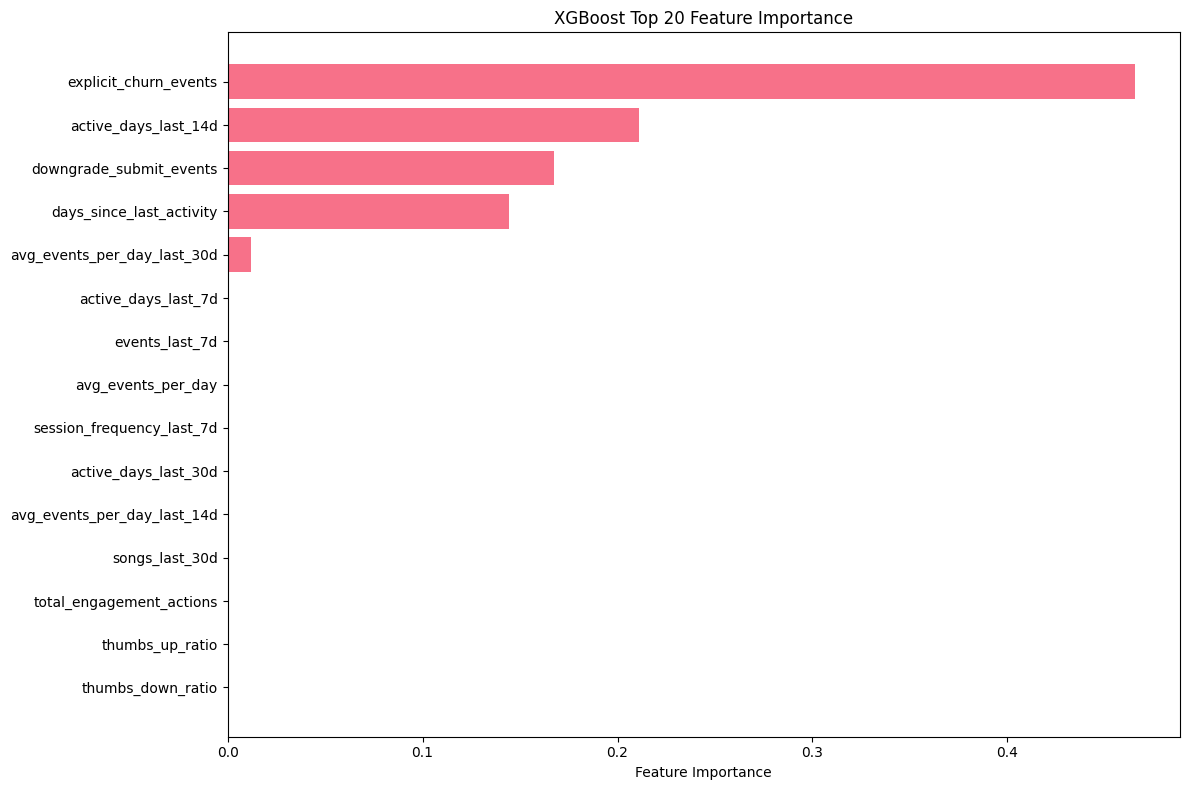

In [6]:
# Display XGBoost feature importance
print("\nTop 15 XGBoost Features by Importance:")
print("-" * 50)
xgb_importance = xgb_results["feature_importance"].head(15)
for i, row in xgb_importance.iterrows():
    print(f"{i+1:2d}. {row['feature']:<35} {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = xgb_importance.head(20)
plt.barh(range(len(top_features)), top_features["importance"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Feature Importance")
plt.title("XGBoost Top 20 Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. LightGBM Model Training

In [7]:
# Train LightGBM with default parameters
print("Training LightGBM model...")

lgb_model = LightGBMChurnModel()
lgb_results = lgb_model.train_and_evaluate(X_train, y_train, X_test, y_test, X_val, y_val)

print("LightGBM model trained")
print(f"  Test AUC-ROC: {lgb_results['test_metrics']['auc_roc']:.4f}")
print(f"  Test F1: {lgb_results['test_metrics']['f1_score']:.4f}")
print(f"  Training time: {lgb_results['training_history']['training_time_seconds']:.2f}s")

INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.03 seconds


INFO:models.ensemble_models:LightGBM evaluation completed:


INFO:models.ensemble_models:  Test AUC-ROC: 0.9924


INFO:models.ensemble_models:  Test F1: 0.9000


Training LightGBM model...
LightGBM model trained
  Test AUC-ROC: 0.9924
  Test F1: 0.9000
  Training time: 0.03s



Top 15 LightGBM Features by Importance:
--------------------------------------------------
 8. avg_events_per_day_last_14d         2.0000
45. explicit_churn_events               2.0000
 2. activity_span_days                  1.0000
 1. total_events                        1.0000
 4. events_last_7d                      0.0000
 5. active_days_last_7d                 0.0000
 6. session_frequency_last_7d           0.0000
 7. active_days_last_14d                0.0000
 9. active_days_last_30d                0.0000
10. songs_last_30d                      0.0000
11. avg_events_per_day_last_30d         0.0000
12. days_since_last_activity            0.0000
13. total_engagement_actions            0.0000
14. thumbs_up_ratio                     0.0000
15. thumbs_down_ratio                   0.0000


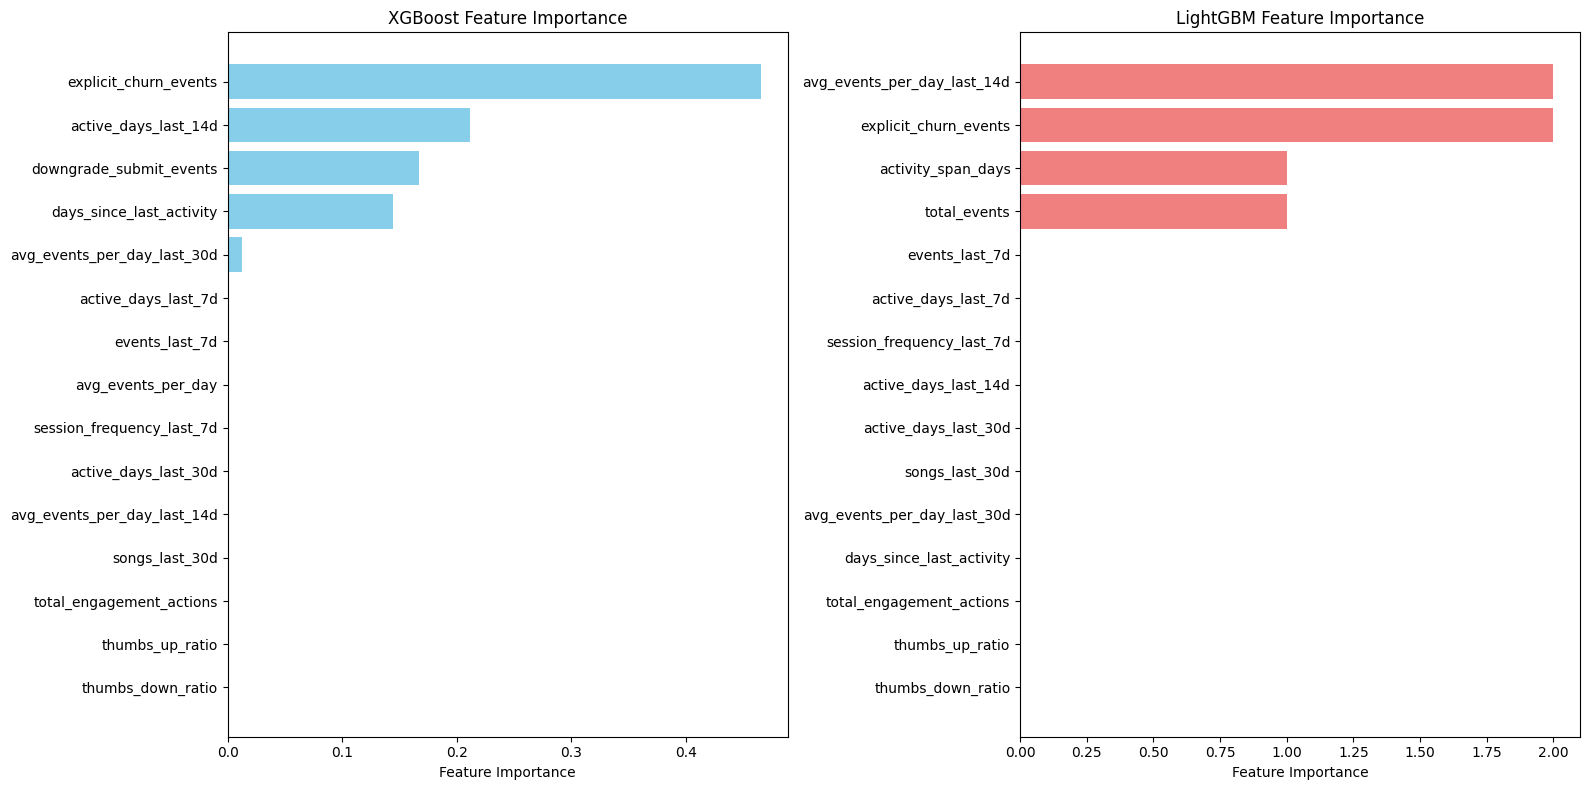

In [8]:
# Display LightGBM feature importance
print("\nTop 15 LightGBM Features by Importance:")
print("-" * 50)
lgb_importance = lgb_results["feature_importance"].head(15)
for i, row in lgb_importance.iterrows():
    print(f"{i+1:2d}. {row['feature']:<35} {row['importance']:.4f}")

# Plot feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# XGBoost importance
top_xgb = xgb_results["feature_importance"].head(15)
ax1.barh(range(len(top_xgb)), top_xgb["importance"], color="skyblue")
ax1.set_yticks(range(len(top_xgb)))
ax1.set_yticklabels(top_xgb["feature"])
ax1.set_xlabel("Feature Importance")
ax1.set_title("XGBoost Feature Importance")
ax1.invert_yaxis()

# LightGBM importance
top_lgb = lgb_results["feature_importance"].head(15)
ax2.barh(range(len(top_lgb)), top_lgb["importance"], color="lightcoral")
ax2.set_yticks(range(len(top_lgb)))
ax2.set_yticklabels(top_lgb["feature"])
ax2.set_xlabel("Feature Importance")
ax2.set_title("LightGBM Feature Importance")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Hyperparameter Optimization

In [9]:
# Hyperparameter optimization for XGBoost
print("Running hyperparameter optimization for XGBoost...")
print("(This may take several minutes)")

xgb_optimizer = EnsembleModelOptimizer(model_type="xgboost", n_trials=50)  # Reduced for demo
xgb_opt_results = xgb_optimizer.optimize(X_train, y_train, X_val, y_val)

print("\nXGBoost optimization completed")
print(f"  Best validation AUC-ROC: {xgb_opt_results['best_score']:.4f}")
print(f"  Optimization time: {xgb_opt_results['optimization_time_seconds']:.1f}s")
print(f"  Best parameters: {xgb_opt_results['best_params']}")

INFO:models.ensemble_models:Starting hyperparameter optimization for xgboost...


INFO:models.ensemble_models:Running 50 trials


[I 2025-08-16 08:18:25,499] A new study created in memory with name: no-name-a5cd39d7-ecc0-4e38-b107-a8808a15c357


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.13272886362306507, 'n_estimators': 155, 'subsample': 0.9178789740330949, 'colsample_bytree': 0.9707991480102799, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.1644145795208818, 'reg_lambda': 7.735848959275326}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,514] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.13272886362306507, 'n_estimators': 155, 'subsample': 0.9178789740330949, 'colsample_bytree': 0.9707991480102799, 'reg_alpha': 0.1644145795208818, 'reg_lambda': 7.735848959275326}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.08406274536764348, 'n_estimators': 280, 'subsample': 0.9120266288221942, 'colsample_bytree': 0.6764399960053361, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.7415998999592164, 'reg_lambda': 0.4783315426460055}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,526] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.08406274536764348, 'n_estimators': 280, 'subsample': 0.9120266288221942, 'colsample_bytree': 0.6764399960053361, 'reg_alpha': 1.7415998999592164, 'reg_lambda': 0.4783315426460055}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.014817474616026048, 'n_estimators': 149, 'subsample': 0.7499067374802015, 'colsample_bytree': 0.6287015308943547, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 7.06273772091569, 'reg_lambda': 6.027147683210053}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


Running hyperparameter optimization for XGBoost...
(This may take several minutes)


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,537] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.014817474616026048, 'n_estimators': 149, 'subsample': 0.7499067374802015, 'colsample_bytree': 0.6287015308943547, 'reg_alpha': 7.06273772091569, 'reg_lambda': 6.027147683210053}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'learning_rate': 0.07004882866490657, 'n_estimators': 296, 'subsample': 0.8185996009796672, 'colsample_bytree': 0.9644524214622576, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 3.6083497649289606, 'reg_lambda': 4.841035076272153}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,549] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 4, 'learning_rate': 0.07004882866490657, 'n_estimators': 296, 'subsample': 0.8185996009796672, 'colsample_bytree': 0.9644524214622576, 'reg_alpha': 3.6083497649289606, 'reg_lambda': 4.841035076272153}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.2594394740736357, 'n_estimators': 164, 'subsample': 0.6701819041064644, 'colsample_bytree': 0.9393736795599487, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.3030908118630435, 'reg_lambda': 1.4842788674705276}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,561] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.2594394740736357, 'n_estimators': 164, 'subsample': 0.6701819041064644, 'colsample_bytree': 0.9393736795599487, 'reg_alpha': 1.3030908118630435, 'reg_lambda': 1.4842788674705276}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.03728138010128202, 'n_estimators': 271, 'subsample': 0.6949445181314715, 'colsample_bytree': 0.968162955065906, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 4.770260754246847, 'reg_lambda': 6.397004019437348}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,572] Trial 5 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.03728138010128202, 'n_estimators': 271, 'subsample': 0.6949445181314715, 'colsample_bytree': 0.968162955065906, 'reg_alpha': 4.770260754246847, 'reg_lambda': 6.397004019437348}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.11923330794017575, 'n_estimators': 85, 'subsample': 0.8340444550038348, 'colsample_bytree': 0.7968962119082825, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 5.517419250718848, 'reg_lambda': 5.121206633153116}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,583] Trial 6 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.11923330794017575, 'n_estimators': 85, 'subsample': 0.8340444550038348, 'colsample_bytree': 0.7968962119082825, 'reg_alpha': 5.517419250718848, 'reg_lambda': 5.121206633153116}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'learning_rate': 0.25979142659284993, 'n_estimators': 113, 'subsample': 0.6826322110260378, 'colsample_bytree': 0.9509603917380743, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 4.411978053051829, 'reg_lambda': 8.230884807189335}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,595] Trial 7 finished with value: 1.0 and parameters: {'max_depth': 3, 'learning_rate': 0.25979142659284993, 'n_estimators': 113, 'subsample': 0.6826322110260378, 'colsample_bytree': 0.9509603917380743, 'reg_alpha': 4.411978053051829, 'reg_lambda': 8.230884807189335}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'learning_rate': 0.07332060212092477, 'n_estimators': 129, 'subsample': 0.852456781216029, 'colsample_bytree': 0.9404738151628739, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 6.850091481131564, 'reg_lambda': 5.716727204109157}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,610] Trial 8 finished with value: 1.0 and parameters: {'max_depth': 3, 'learning_rate': 0.07332060212092477, 'n_estimators': 129, 'subsample': 0.852456781216029, 'colsample_bytree': 0.9404738151628739, 'reg_alpha': 6.850091481131564, 'reg_lambda': 5.716727204109157}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.06834466709044493, 'n_estimators': 91, 'subsample': 0.9604489236571062, 'colsample_bytree': 0.626857399350383, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 4.057758943848376, 'reg_lambda': 7.355904711307726}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,622] Trial 9 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.06834466709044493, 'n_estimators': 91, 'subsample': 0.9604489236571062, 'colsample_bytree': 0.626857399350383, 'reg_alpha': 4.057758943848376, 'reg_lambda': 7.355904711307726}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.028861562250986756, 'n_estimators': 216, 'subsample': 0.9894551373478268, 'colsample_bytree': 0.8425486863918115, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 9.880264447126265, 'reg_lambda': 9.748652016628021}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,643] Trial 10 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.028861562250986756, 'n_estimators': 216, 'subsample': 0.9894551373478268, 'colsample_bytree': 0.8425486863918115, 'reg_alpha': 9.880264447126265, 'reg_lambda': 9.748652016628021}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.13505521722211253, 'n_estimators': 212, 'subsample': 0.9134871748684721, 'colsample_bytree': 0.733505213518051, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.025119012515516737, 'reg_lambda': 0.016760781770185418}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.02 seconds


[I 2025-08-16 08:18:25,675] Trial 11 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.13505521722211253, 'n_estimators': 212, 'subsample': 0.9134871748684721, 'colsample_bytree': 0.733505213518051, 'reg_alpha': 0.025119012515516737, 'reg_lambda': 0.016760781770185418}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.13447471004310876, 'n_estimators': 215, 'subsample': 0.9049432701283407, 'colsample_bytree': 0.7050186448799959, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.0833202582292953, 'reg_lambda': 3.2570646671894083}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,696] Trial 12 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.13447471004310876, 'n_estimators': 215, 'subsample': 0.9049432701283407, 'colsample_bytree': 0.7050186448799959, 'reg_alpha': 2.0833202582292953, 'reg_lambda': 3.2570646671894083}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.11561923102708253, 'n_estimators': 53, 'subsample': 0.9141477843402165, 'colsample_bytree': 0.855338964904981, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.029995657714339874, 'reg_lambda': 3.1714807629468362}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,716] Trial 13 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.11561923102708253, 'n_estimators': 53, 'subsample': 0.9141477843402165, 'colsample_bytree': 0.855338964904981, 'reg_alpha': 0.029995657714339874, 'reg_lambda': 3.1714807629468362}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.037975451750588717, 'n_estimators': 248, 'subsample': 0.7784255507130522, 'colsample_bytree': 0.7009103398905645, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.2601510147398782, 'reg_lambda': 9.74859690350072}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,737] Trial 14 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.037975451750588717, 'n_estimators': 248, 'subsample': 0.7784255507130522, 'colsample_bytree': 0.7009103398905645, 'reg_alpha': 2.2601510147398782, 'reg_lambda': 9.74859690350072}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.18686159338959388, 'n_estimators': 181, 'subsample': 0.6139774115372095, 'colsample_bytree': 0.7706177167926587, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.381375143488023, 'reg_lambda': 3.589336174498114}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,757] Trial 15 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.18686159338959388, 'n_estimators': 181, 'subsample': 0.6139774115372095, 'colsample_bytree': 0.7706177167926587, 'reg_alpha': 1.381375143488023, 'reg_lambda': 3.589336174498114}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.02221460017260915, 'n_estimators': 185, 'subsample': 0.8725779829898048, 'colsample_bytree': 0.8847586145897666, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.998562026259966, 'reg_lambda': 8.097521661265985}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,776] Trial 16 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.02221460017260915, 'n_estimators': 185, 'subsample': 0.8725779829898048, 'colsample_bytree': 0.8847586145897666, 'reg_alpha': 2.998562026259966, 'reg_lambda': 8.097521661265985}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.04503724947890639, 'n_estimators': 249, 'subsample': 0.955057766178628, 'colsample_bytree': 0.6750847605271785, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.0018171073193356, 'reg_lambda': 0.27575746949865554}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,796] Trial 17 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.04503724947890639, 'n_estimators': 249, 'subsample': 0.955057766178628, 'colsample_bytree': 0.6750847605271785, 'reg_alpha': 1.0018171073193356, 'reg_lambda': 0.27575746949865554}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.010077397407046069, 'n_estimators': 143, 'subsample': 0.8773738676262534, 'colsample_bytree': 0.8945010655003589, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.6155842842692967, 'reg_lambda': 2.4187850633444112}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,815] Trial 18 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.010077397407046069, 'n_estimators': 143, 'subsample': 0.8773738676262534, 'colsample_bytree': 0.8945010655003589, 'reg_alpha': 2.6155842842692967, 'reg_lambda': 2.4187850633444112}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'learning_rate': 0.09165759546473977, 'n_estimators': 298, 'subsample': 0.9941304462886862, 'colsample_bytree': 0.9997370392466559, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 9.333617048802685, 'reg_lambda': 7.285152624884094}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,837] Trial 19 finished with value: 1.0 and parameters: {'max_depth': 4, 'learning_rate': 0.09165759546473977, 'n_estimators': 298, 'subsample': 0.9941304462886862, 'colsample_bytree': 0.9997370392466559, 'reg_alpha': 9.333617048802685, 'reg_lambda': 7.285152624884094}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.17844690237001715, 'n_estimators': 241, 'subsample': 0.9306649488230672, 'colsample_bytree': 0.7607984574520993, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 5.956408277840752, 'reg_lambda': 1.4326170262379225}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,858] Trial 20 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.17844690237001715, 'n_estimators': 241, 'subsample': 0.9306649488230672, 'colsample_bytree': 0.7607984574520993, 'reg_alpha': 5.956408277840752, 'reg_lambda': 1.4326170262379225}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.015118063670140257, 'n_estimators': 155, 'subsample': 0.7740779289383635, 'colsample_bytree': 0.6151107008220604, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 7.5718134695168455, 'reg_lambda': 6.659956197757605}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,885] Trial 21 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.015118063670140257, 'n_estimators': 155, 'subsample': 0.7740779289383635, 'colsample_bytree': 0.6151107008220604, 'reg_alpha': 7.5718134695168455, 'reg_lambda': 6.659956197757605}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.019506103728953054, 'n_estimators': 188, 'subsample': 0.7226240084798036, 'colsample_bytree': 0.6554310581281158, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 7.8760965546680755, 'reg_lambda': 4.433516738024532}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,906] Trial 22 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.019506103728953054, 'n_estimators': 188, 'subsample': 0.7226240084798036, 'colsample_bytree': 0.6554310581281158, 'reg_alpha': 7.8760965546680755, 'reg_lambda': 4.433516738024532}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.04776580373987496, 'n_estimators': 130, 'subsample': 0.7597840679878322, 'colsample_bytree': 0.6014607270454042, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 6.566104453817328, 'reg_lambda': 8.714791919174726}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,927] Trial 23 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.04776580373987496, 'n_estimators': 130, 'subsample': 0.7597840679878322, 'colsample_bytree': 0.6014607270454042, 'reg_alpha': 6.566104453817328, 'reg_lambda': 8.714791919174726}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'learning_rate': 0.09002771584992889, 'n_estimators': 104, 'subsample': 0.8014148650332159, 'colsample_bytree': 0.6421390775364029, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 8.5094022601433, 'reg_lambda': 5.662338624560906}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:25,964] Trial 24 finished with value: 1.0 and parameters: {'max_depth': 4, 'learning_rate': 0.09002771584992889, 'n_estimators': 104, 'subsample': 0.8014148650332159, 'colsample_bytree': 0.6421390775364029, 'reg_alpha': 8.5094022601433, 'reg_lambda': 5.662338624560906}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.17635164554554975, 'n_estimators': 161, 'subsample': 0.7294849665344714, 'colsample_bytree': 0.6835666652063677, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.2736018421971507, 'reg_lambda': 6.54958880001749}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.02 seconds


[I 2025-08-16 08:18:25,996] Trial 25 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.17635164554554975, 'n_estimators': 161, 'subsample': 0.7294849665344714, 'colsample_bytree': 0.6835666652063677, 'reg_alpha': 0.2736018421971507, 'reg_lambda': 6.54958880001749}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.012814420940419395, 'n_estimators': 198, 'subsample': 0.8771811494340774, 'colsample_bytree': 0.7405167234235038, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.8975216962820751, 'reg_lambda': 4.207850170625905}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,017] Trial 26 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.012814420940419395, 'n_estimators': 198, 'subsample': 0.8771811494340774, 'colsample_bytree': 0.7405167234235038, 'reg_alpha': 0.8975216962820751, 'reg_lambda': 4.207850170625905}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.057026137997549485, 'n_estimators': 138, 'subsample': 0.6271591058833497, 'colsample_bytree': 0.7208820548961262, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 3.6175647118857652, 'reg_lambda': 7.428255750614992}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,037] Trial 27 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.057026137997549485, 'n_estimators': 138, 'subsample': 0.6271591058833497, 'colsample_bytree': 0.7208820548961262, 'reg_alpha': 3.6175647118857652, 'reg_lambda': 7.428255750614992}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.09930039654653795, 'n_estimators': 270, 'subsample': 0.9571570801712762, 'colsample_bytree': 0.8081414138767768, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 5.509913615354803, 'reg_lambda': 9.157875518516732}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,058] Trial 28 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.09930039654653795, 'n_estimators': 270, 'subsample': 0.9571570801712762, 'colsample_bytree': 0.8081414138767768, 'reg_alpha': 5.509913615354803, 'reg_lambda': 9.157875518516732}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.06989673588204756, 'n_estimators': 74, 'subsample': 0.8156424363843423, 'colsample_bytree': 0.6624948416623063, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.8612751771005058, 'reg_lambda': 5.752609229773893}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,081] Trial 29 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.06989673588204756, 'n_estimators': 74, 'subsample': 0.8156424363843423, 'colsample_bytree': 0.6624948416623063, 'reg_alpha': 1.8612751771005058, 'reg_lambda': 5.752609229773893}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.02638679767433775, 'n_estimators': 279, 'subsample': 0.8375309136835017, 'colsample_bytree': 0.6337793278803856, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 3.229892333488853, 'reg_lambda': 2.3350443111841734}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,106] Trial 30 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.02638679767433775, 'n_estimators': 279, 'subsample': 0.8375309136835017, 'colsample_bytree': 0.6337793278803856, 'reg_alpha': 3.229892333488853, 'reg_lambda': 2.3350443111841734}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'learning_rate': 0.06253345034183853, 'n_estimators': 284, 'subsample': 0.74058597733629, 'colsample_bytree': 0.9825554896296751, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.5313163722506244, 'reg_lambda': 1.593659783559231}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,127] Trial 31 finished with value: 1.0 and parameters: {'max_depth': 4, 'learning_rate': 0.06253345034183853, 'n_estimators': 284, 'subsample': 0.74058597733629, 'colsample_bytree': 0.9825554896296751, 'reg_alpha': 1.5313163722506244, 'reg_lambda': 1.593659783559231}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'learning_rate': 0.1570405471065336, 'n_estimators': 300, 'subsample': 0.6512224951930521, 'colsample_bytree': 0.9140961598819943, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 3.8054536419836777, 'reg_lambda': 4.787005156006247}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,148] Trial 32 finished with value: 1.0 and parameters: {'max_depth': 4, 'learning_rate': 0.1570405471065336, 'n_estimators': 300, 'subsample': 0.6512224951930521, 'colsample_bytree': 0.9140961598819943, 'reg_alpha': 3.8054536419836777, 'reg_lambda': 4.787005156006247}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'learning_rate': 0.21854808338525655, 'n_estimators': 165, 'subsample': 0.7024610765905691, 'colsample_bytree': 0.9179260627389644, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.633533143244033, 'reg_lambda': 6.7240645501844085}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,169] Trial 33 finished with value: 1.0 and parameters: {'max_depth': 3, 'learning_rate': 0.21854808338525655, 'n_estimators': 165, 'subsample': 0.7024610765905691, 'colsample_bytree': 0.9179260627389644, 'reg_alpha': 2.633533143244033, 'reg_lambda': 6.7240645501844085}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.08257315890375352, 'n_estimators': 114, 'subsample': 0.8164579320136516, 'colsample_bytree': 0.9588446928749165, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.7569569490553226, 'reg_lambda': 8.25512378804046}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,190] Trial 34 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.08257315890375352, 'n_estimators': 114, 'subsample': 0.8164579320136516, 'colsample_bytree': 0.9588446928749165, 'reg_alpha': 0.7569569490553226, 'reg_lambda': 8.25512378804046}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'learning_rate': 0.03416883424101945, 'n_estimators': 259, 'subsample': 0.8560476369369632, 'colsample_bytree': 0.9796214964913404, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 4.662393372495913, 'reg_lambda': 0.7774680956340336}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,216] Trial 35 finished with value: 1.0 and parameters: {'max_depth': 4, 'learning_rate': 0.03416883424101945, 'n_estimators': 259, 'subsample': 0.8560476369369632, 'colsample_bytree': 0.9796214964913404, 'reg_alpha': 4.662393372495913, 'reg_lambda': 0.7774680956340336}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'learning_rate': 0.28225117660813837, 'n_estimators': 235, 'subsample': 0.8862953513478797, 'colsample_bytree': 0.8100535730466317, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 5.31887100349538, 'reg_lambda': 5.346103108575385}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,237] Trial 36 finished with value: 1.0 and parameters: {'max_depth': 3, 'learning_rate': 0.28225117660813837, 'n_estimators': 235, 'subsample': 0.8862953513478797, 'colsample_bytree': 0.8100535730466317, 'reg_alpha': 5.31887100349538, 'reg_lambda': 5.346103108575385}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.11467661032183013, 'n_estimators': 228, 'subsample': 0.9373619969147649, 'colsample_bytree': 0.9358863635463291, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 6.73602958806113, 'reg_lambda': 6.14496345147458}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,261] Trial 37 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.11467661032183013, 'n_estimators': 228, 'subsample': 0.9373619969147649, 'colsample_bytree': 0.9358863635463291, 'reg_alpha': 6.73602958806113, 'reg_lambda': 6.14496345147458}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.04899354837800291, 'n_estimators': 147, 'subsample': 0.849129149693247, 'colsample_bytree': 0.8484811185875869, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.6101323231013756, 'reg_lambda': 7.739181365439078}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,282] Trial 38 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.04899354837800291, 'n_estimators': 147, 'subsample': 0.849129149693247, 'colsample_bytree': 0.8484811185875869, 'reg_alpha': 0.6101323231013756, 'reg_lambda': 7.739181365439078}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.07687169184122342, 'n_estimators': 170, 'subsample': 0.7819366380350685, 'colsample_bytree': 0.8876163673197819, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 6.072048894098588, 'reg_lambda': 3.9127676424934874}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,304] Trial 39 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.07687169184122342, 'n_estimators': 170, 'subsample': 0.7819366380350685, 'colsample_bytree': 0.8876163673197819, 'reg_alpha': 6.072048894098588, 'reg_lambda': 3.9127676424934874}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.13940467268681359, 'n_estimators': 202, 'subsample': 0.8962290826293448, 'colsample_bytree': 0.9970932478899965, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 4.365847109437998, 'reg_lambda': 4.998922137908281}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,328] Trial 40 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.13940467268681359, 'n_estimators': 202, 'subsample': 0.8962290826293448, 'colsample_bytree': 0.9970932478899965, 'reg_alpha': 4.365847109437998, 'reg_lambda': 4.998922137908281}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.2417101821082927, 'n_estimators': 115, 'subsample': 0.7038268785382962, 'colsample_bytree': 0.9567708005350178, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.4552774768354344, 'reg_lambda': 0.9538129359560692}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,353] Trial 41 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.2417101821082927, 'n_estimators': 115, 'subsample': 0.7038268785382962, 'colsample_bytree': 0.9567708005350178, 'reg_alpha': 1.4552774768354344, 'reg_lambda': 0.9538129359560692}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.10602960261092358, 'n_estimators': 126, 'subsample': 0.6660266764244503, 'colsample_bytree': 0.9379407321148147, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.8344951332917343, 'reg_lambda': 2.0278830486157258}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,375] Trial 42 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.10602960261092358, 'n_estimators': 126, 'subsample': 0.6660266764244503, 'colsample_bytree': 0.9379407321148147, 'reg_alpha': 1.8344951332917343, 'reg_lambda': 2.0278830486157258}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.22744073178865634, 'n_estimators': 172, 'subsample': 0.6742815766319529, 'colsample_bytree': 0.8704241860360539, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.295975185177495, 'reg_lambda': 2.6652631835379417}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,397] Trial 43 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.22744073178865634, 'n_estimators': 172, 'subsample': 0.6742815766319529, 'colsample_bytree': 0.8704241860360539, 'reg_alpha': 2.295975185177495, 'reg_lambda': 2.6652631835379417}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.12894728116214393, 'n_estimators': 287, 'subsample': 0.9230679398289503, 'colsample_bytree': 0.9217167142331403, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.328086721224465, 'reg_lambda': 0.5127435337436408}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,419] Trial 44 finished with value: 1.0 and parameters: {'max_depth': 5, 'learning_rate': 0.12894728116214393, 'n_estimators': 287, 'subsample': 0.9230679398289503, 'colsample_bytree': 0.9217167142331403, 'reg_alpha': 0.328086721224465, 'reg_lambda': 0.5127435337436408}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.04027352779390125, 'n_estimators': 261, 'subsample': 0.6497640524372006, 'colsample_bytree': 0.8261168215655603, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 1.2451226729907872, 'reg_lambda': 1.2800311177332961}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,442] Trial 45 finished with value: 1.0 and parameters: {'max_depth': 9, 'learning_rate': 0.04027352779390125, 'n_estimators': 261, 'subsample': 0.6497640524372006, 'colsample_bytree': 0.8261168215655603, 'reg_alpha': 1.2451226729907872, 'reg_lambda': 1.2800311177332961}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'learning_rate': 0.06758913720178962, 'n_estimators': 153, 'subsample': 0.9723003325043382, 'colsample_bytree': 0.9713815314705425, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 2.471033050371604, 'reg_lambda': 3.0748703683043432}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,464] Trial 46 finished with value: 1.0 and parameters: {'max_depth': 3, 'learning_rate': 0.06758913720178962, 'n_estimators': 153, 'subsample': 0.9723003325043382, 'colsample_bytree': 0.9713815314705425, 'reg_alpha': 2.471033050371604, 'reg_lambda': 3.0748703683043432}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.05574039912108775, 'n_estimators': 193, 'subsample': 0.6016042613154502, 'colsample_bytree': 0.775484903361499, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 3.168199170281591, 'reg_lambda': 1.796435576638902}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,494] Trial 47 finished with value: 1.0 and parameters: {'max_depth': 10, 'learning_rate': 0.05574039912108775, 'n_estimators': 193, 'subsample': 0.6016042613154502, 'colsample_bytree': 0.775484903361499, 'reg_alpha': 3.168199170281591, 'reg_lambda': 1.796435576638902}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.293539474947616, 'n_estimators': 220, 'subsample': 0.7535688788762, 'colsample_bytree': 0.6996661105687094, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 4.923382875965741, 'reg_lambda': 6.976529941571335}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,516] Trial 48 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.293539474947616, 'n_estimators': 220, 'subsample': 0.7535688788762, 'colsample_bytree': 0.6996661105687094, 'reg_alpha': 4.923382875965741, 'reg_lambda': 6.976529941571335}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.14887778627519416, 'n_estimators': 177, 'subsample': 0.9415602584146779, 'colsample_bytree': 0.9490090472998685, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 7.388174937586331, 'reg_lambda': 0.2722036937966817}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,538] Trial 49 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.14887778627519416, 'n_estimators': 177, 'subsample': 0.9415602584146779, 'colsample_bytree': 0.9490090472998685, 'reg_alpha': 7.388174937586331, 'reg_lambda': 0.2722036937966817}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Optimization completed in 1.04 seconds


INFO:models.ensemble_models:Best AUC-ROC: 1.0000


INFO:models.ensemble_models:Best parameters: {'max_depth': 9, 'learning_rate': 0.13272886362306507, 'n_estimators': 155, 'subsample': 0.9178789740330949, 'colsample_bytree': 0.9707991480102799, 'reg_alpha': 0.1644145795208818, 'reg_lambda': 7.735848959275326}



XGBoost optimization completed
  Best validation AUC-ROC: 1.0000
  Optimization time: 1.0s
  Best parameters: {'max_depth': 9, 'learning_rate': 0.13272886362306507, 'n_estimators': 155, 'subsample': 0.9178789740330949, 'colsample_bytree': 0.9707991480102799, 'reg_alpha': 0.1644145795208818, 'reg_lambda': 7.735848959275326}


In [10]:
# Train optimized XGBoost model
print("Training optimized XGBoost model...")

xgb_optimized = xgb_optimizer.get_optimized_model()
xgb_opt_results_full = xgb_optimized.train_and_evaluate(X_train, y_train, X_test, y_test, X_val, y_val)

print("Optimized XGBoost model trained")
print(f"  Test AUC-ROC: {xgb_opt_results_full['test_metrics']['auc_roc']:.4f}")
print(f"  Test F1: {xgb_opt_results_full['test_metrics']['f1_score']:.4f}")

# Compare with default XGBoost
improvement = xgb_opt_results_full["test_metrics"]["auc_roc"] - xgb_results["test_metrics"]["auc_roc"]
print(f"  Improvement over default: {improvement:.4f} AUC-ROC")

INFO:models.ensemble_models:Initialized XGBoost with parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.13272886362306507, 'n_estimators': 155, 'subsample': 0.9178789740330949, 'colsample_bytree': 0.9707991480102799, 'random_state': 42, 'early_stopping_rounds': 10, 'scale_pos_weight': 1, 'reg_alpha': 0.1644145795208818, 'reg_lambda': 7.735848959275326}


INFO:models.ensemble_models:Adjusted scale_pos_weight to 1.109


INFO:models.ensemble_models:Training XGBoost on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


INFO:models.ensemble_models:XGBoost evaluation completed:


INFO:models.ensemble_models:  Test AUC-ROC: 0.9962


INFO:models.ensemble_models:  Test F1: 0.9778


Training optimized XGBoost model...
Optimized XGBoost model trained
  Test AUC-ROC: 0.9962
  Test F1: 0.9778
  Improvement over default: 0.0000 AUC-ROC


In [11]:
# Hyperparameter optimization for LightGBM
print("Running hyperparameter optimization for LightGBM...")
print("(This may take several minutes)")

lgb_optimizer = EnsembleModelOptimizer(model_type="lightgbm", n_trials=50)  # Reduced for demo
lgb_opt_results = lgb_optimizer.optimize(X_train, y_train, X_val, y_val)

print("\nLightGBM optimization completed")
print(f"  Best validation AUC-ROC: {lgb_opt_results['best_score']:.4f}")
print(f"  Optimization time: {lgb_opt_results['optimization_time_seconds']:.1f}s")
print(f"  Best parameters: {lgb_opt_results['best_params']}")

INFO:models.ensemble_models:Starting hyperparameter optimization for lightgbm...


INFO:models.ensemble_models:Running 50 trials


[I 2025-08-16 08:18:26,573] A new study created in memory with name: no-name-ae9875df-b4c2-4ac5-972a-19e46c5b5ebd


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 245, 'learning_rate': 0.18855839159379753, 'n_estimators': 86, 'subsample': 0.7577222979695715, 'colsample_bytree': 0.9463856643667922, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.178763193906217, 'reg_lambda': 8.53659809190271, 'min_child_samples': 7}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,581] Trial 0 finished with value: 1.0 and parameters: {'num_leaves': 245, 'learning_rate': 0.18855839159379753, 'n_estimators': 86, 'subsample': 0.7577222979695715, 'colsample_bytree': 0.9463856643667922, 'reg_alpha': 2.178763193906217, 'reg_lambda': 8.53659809190271, 'min_child_samples': 7}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 18, 'learning_rate': 0.2548178550466179, 'n_estimators': 172, 'subsample': 0.7811332103923432, 'colsample_bytree': 0.9463376127201184, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 9.971132390595365, 'reg_lambda': 4.440983534861584, 'min_child_samples': 92}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,585] Trial 1 finished with value: 0.5 and parameters: {'num_leaves': 18, 'learning_rate': 0.2548178550466179, 'n_estimators': 172, 'subsample': 0.7811332103923432, 'colsample_bytree': 0.9463376127201184, 'reg_alpha': 9.971132390595365, 'reg_lambda': 4.440983534861584, 'min_child_samples': 92}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.04648435478325278, 'n_estimators': 176, 'subsample': 0.9073022789156054, 'colsample_bytree': 0.9303602948945229, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 0.6833143098547323, 'reg_lambda': 2.7606897163094657, 'min_child_samples': 95}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,590] Trial 2 finished with value: 0.5 and parameters: {'num_leaves': 220, 'learning_rate': 0.04648435478325278, 'n_estimators': 176, 'subsample': 0.9073022789156054, 'colsample_bytree': 0.9303602948945229, 'reg_alpha': 0.6833143098547323, 'reg_lambda': 2.7606897163094657, 'min_child_samples': 95}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 73, 'learning_rate': 0.0668046672366131, 'n_estimators': 183, 'subsample': 0.9155531008520318, 'colsample_bytree': 0.9573494082957742, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 8.03901076473343, 'reg_lambda': 5.65859081513, 'min_child_samples': 75}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,594] Trial 3 finished with value: 0.5 and parameters: {'num_leaves': 73, 'learning_rate': 0.0668046672366131, 'n_estimators': 183, 'subsample': 0.9155531008520318, 'colsample_bytree': 0.9573494082957742, 'reg_alpha': 8.03901076473343, 'reg_lambda': 5.65859081513, 'min_child_samples': 75}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 273, 'learning_rate': 0.0306491754961883, 'n_estimators': 52, 'subsample': 0.952822778307081, 'colsample_bytree': 0.999400777995988, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.490771146652835, 'reg_lambda': 4.097191997049439, 'min_child_samples': 58}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,601] Trial 4 finished with value: 0.6547619047619048 and parameters: {'num_leaves': 273, 'learning_rate': 0.0306491754961883, 'n_estimators': 52, 'subsample': 0.952822778307081, 'colsample_bytree': 0.999400777995988, 'reg_alpha': 2.490771146652835, 'reg_lambda': 4.097191997049439, 'min_child_samples': 58}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 17, 'learning_rate': 0.1965893235857472, 'n_estimators': 89, 'subsample': 0.6228478972933411, 'colsample_bytree': 0.9534236789764235, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 1.3771591664686855, 'reg_lambda': 7.572011984809182, 'min_child_samples': 65}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,607] Trial 5 finished with value: 0.7708333333333334 and parameters: {'num_leaves': 17, 'learning_rate': 0.1965893235857472, 'n_estimators': 89, 'subsample': 0.6228478972933411, 'colsample_bytree': 0.9534236789764235, 'reg_alpha': 1.3771591664686855, 'reg_lambda': 7.572011984809182, 'min_child_samples': 65}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 129, 'learning_rate': 0.21071495673706828, 'n_estimators': 169, 'subsample': 0.919827166188648, 'colsample_bytree': 0.7192879159428198, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 9.568651796203511, 'reg_lambda': 1.960754271833015, 'min_child_samples': 55}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,613] Trial 6 finished with value: 0.9940476190476191 and parameters: {'num_leaves': 129, 'learning_rate': 0.21071495673706828, 'n_estimators': 169, 'subsample': 0.919827166188648, 'colsample_bytree': 0.7192879159428198, 'reg_alpha': 9.568651796203511, 'reg_lambda': 1.960754271833015, 'min_child_samples': 55}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.015401602281315579, 'n_estimators': 243, 'subsample': 0.7753193304824595, 'colsample_bytree': 0.8946962910834706, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 0.9275174763482252, 'reg_lambda': 0.9111216504689068, 'min_child_samples': 59}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,619] Trial 7 finished with value: 0.6547619047619048 and parameters: {'num_leaves': 24, 'learning_rate': 0.015401602281315579, 'n_estimators': 243, 'subsample': 0.7753193304824595, 'colsample_bytree': 0.8946962910834706, 'reg_alpha': 0.9275174763482252, 'reg_lambda': 0.9111216504689068, 'min_child_samples': 59}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 211, 'learning_rate': 0.04442840315228483, 'n_estimators': 66, 'subsample': 0.8078527995086844, 'colsample_bytree': 0.9314172958513796, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 0.7813101415545975, 'reg_lambda': 5.623473934728302, 'min_child_samples': 81}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,624] Trial 8 finished with value: 0.5 and parameters: {'num_leaves': 211, 'learning_rate': 0.04442840315228483, 'n_estimators': 66, 'subsample': 0.8078527995086844, 'colsample_bytree': 0.9314172958513796, 'reg_alpha': 0.7813101415545975, 'reg_lambda': 5.623473934728302, 'min_child_samples': 81}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 271, 'learning_rate': 0.07127733721090279, 'n_estimators': 127, 'subsample': 0.8583362117767706, 'colsample_bytree': 0.8664608528019281, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 7.170519187468301, 'reg_lambda': 4.11866682073117, 'min_child_samples': 63}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,630] Trial 9 finished with value: 0.6547619047619048 and parameters: {'num_leaves': 271, 'learning_rate': 0.07127733721090279, 'n_estimators': 127, 'subsample': 0.8583362117767706, 'colsample_bytree': 0.8664608528019281, 'reg_alpha': 7.170519187468301, 'reg_lambda': 4.11866682073117, 'min_child_samples': 63}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 176, 'learning_rate': 0.11749168149845349, 'n_estimators': 289, 'subsample': 0.6738386867614904, 'colsample_bytree': 0.628920575117172, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.9860161236142204, 'reg_lambda': 9.787578698140848, 'min_child_samples': 7}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,647] Trial 10 finished with value: 0.9999999999999999 and parameters: {'num_leaves': 176, 'learning_rate': 0.11749168149845349, 'n_estimators': 289, 'subsample': 0.6738386867614904, 'colsample_bytree': 0.628920575117172, 'reg_alpha': 3.9860161236142204, 'reg_lambda': 9.787578698140848, 'min_child_samples': 7}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 175, 'learning_rate': 0.11980443808621817, 'n_estimators': 284, 'subsample': 0.680245161522407, 'colsample_bytree': 0.6129543813183852, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 4.31799977181999, 'reg_lambda': 9.922723933256275, 'min_child_samples': 7}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,663] Trial 11 finished with value: 0.9999999999999999 and parameters: {'num_leaves': 175, 'learning_rate': 0.11980443808621817, 'n_estimators': 284, 'subsample': 0.680245161522407, 'colsample_bytree': 0.6129543813183852, 'reg_alpha': 4.31799977181999, 'reg_lambda': 9.922723933256275, 'min_child_samples': 7}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 126, 'learning_rate': 0.11813473077813212, 'n_estimators': 295, 'subsample': 0.7010591757348889, 'colsample_bytree': 0.790742049942303, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.8967109527515373, 'reg_lambda': 9.872100083763065, 'min_child_samples': 6}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,681] Trial 12 finished with value: 1.0 and parameters: {'num_leaves': 126, 'learning_rate': 0.11813473077813212, 'n_estimators': 295, 'subsample': 0.7010591757348889, 'colsample_bytree': 0.790742049942303, 'reg_alpha': 3.8967109527515373, 'reg_lambda': 9.872100083763065, 'min_child_samples': 6}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 118, 'learning_rate': 0.1193462494695313, 'n_estimators': 241, 'subsample': 0.7079004564955953, 'colsample_bytree': 0.7925507793163857, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.0176075519260994, 'reg_lambda': 7.733625050124771, 'min_child_samples': 28}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,699] Trial 13 finished with value: 1.0 and parameters: {'num_leaves': 118, 'learning_rate': 0.1193462494695313, 'n_estimators': 241, 'subsample': 0.7079004564955953, 'colsample_bytree': 0.7925507793163857, 'reg_alpha': 3.0176075519260994, 'reg_lambda': 7.733625050124771, 'min_child_samples': 28}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 103, 'learning_rate': 0.2901138288654754, 'n_estimators': 112, 'subsample': 0.737405683952624, 'colsample_bytree': 0.8057517353143607, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 6.036916293189575, 'reg_lambda': 8.136410900326945, 'min_child_samples': 32}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,715] Trial 14 finished with value: 1.0 and parameters: {'num_leaves': 103, 'learning_rate': 0.2901138288654754, 'n_estimators': 112, 'subsample': 0.737405683952624, 'colsample_bytree': 0.8057517353143607, 'reg_alpha': 6.036916293189575, 'reg_lambda': 8.136410900326945, 'min_child_samples': 32}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.15818691616925876, 'n_estimators': 218, 'subsample': 0.6249244225237393, 'colsample_bytree': 0.7582749306421419, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 5.453600390136802, 'reg_lambda': 8.654748127064433, 'min_child_samples': 23}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.01 seconds


[I 2025-08-16 08:18:26,733] Trial 15 finished with value: 1.0 and parameters: {'num_leaves': 220, 'learning_rate': 0.15818691616925876, 'n_estimators': 218, 'subsample': 0.6249244225237393, 'colsample_bytree': 0.7582749306421419, 'reg_alpha': 5.453600390136802, 'reg_lambda': 8.654748127064433, 'min_child_samples': 23}. Best is trial 0 with value: 1.0.


Running hyperparameter optimization for LightGBM...
(This may take several minutes)


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 78, 'learning_rate': 0.08808980377996417, 'n_estimators': 134, 'subsample': 0.8365270030970567, 'colsample_bytree': 0.8491639616206207, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.884448342541533, 'reg_lambda': 6.757731238133854, 'min_child_samples': 42}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,750] Trial 16 finished with value: 0.998015873015873 and parameters: {'num_leaves': 78, 'learning_rate': 0.08808980377996417, 'n_estimators': 134, 'subsample': 0.8365270030970567, 'colsample_bytree': 0.8491639616206207, 'reg_alpha': 2.884448342541533, 'reg_lambda': 6.757731238133854, 'min_child_samples': 42}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 297, 'learning_rate': 0.026834956505541973, 'n_estimators': 218, 'subsample': 0.7406833677420384, 'colsample_bytree': 0.6932296071225206, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.21342390614811, 'reg_lambda': 9.00924991161278, 'min_child_samples': 16}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,767] Trial 17 finished with value: 1.0 and parameters: {'num_leaves': 297, 'learning_rate': 0.026834956505541973, 'n_estimators': 218, 'subsample': 0.7406833677420384, 'colsample_bytree': 0.6932296071225206, 'reg_alpha': 2.21342390614811, 'reg_lambda': 9.00924991161278, 'min_child_samples': 16}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 149, 'learning_rate': 0.010677705719874087, 'n_estimators': 268, 'subsample': 0.6624604004908314, 'colsample_bytree': 0.8372949577118589, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.942093990704091, 'reg_lambda': 6.727249224961674, 'min_child_samples': 13}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,783] Trial 18 finished with value: 1.0 and parameters: {'num_leaves': 149, 'learning_rate': 0.010677705719874087, 'n_estimators': 268, 'subsample': 0.6624604004908314, 'colsample_bytree': 0.8372949577118589, 'reg_alpha': 3.942093990704091, 'reg_lambda': 6.727249224961674, 'min_child_samples': 13}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 245, 'learning_rate': 0.15625719053128936, 'n_estimators': 97, 'subsample': 0.7379651829059456, 'colsample_bytree': 0.7315774677420239, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 6.2314037911343, 'reg_lambda': 6.789243564741141, 'min_child_samples': 39}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,800] Trial 19 finished with value: 1.0 and parameters: {'num_leaves': 245, 'learning_rate': 0.15625719053128936, 'n_estimators': 97, 'subsample': 0.7379651829059456, 'colsample_bytree': 0.7315774677420239, 'reg_alpha': 6.2314037911343, 'reg_lambda': 6.789243564741141, 'min_child_samples': 39}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 187, 'learning_rate': 0.08904540933541122, 'n_estimators': 200, 'subsample': 0.8716715650344566, 'colsample_bytree': 0.7818106660512834, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 0.047221489555293594, 'reg_lambda': 9.126147356736872, 'min_child_samples': 44}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,817] Trial 20 finished with value: 0.998015873015873 and parameters: {'num_leaves': 187, 'learning_rate': 0.08904540933541122, 'n_estimators': 200, 'subsample': 0.8716715650344566, 'colsample_bytree': 0.7818106660512834, 'reg_alpha': 0.047221489555293594, 'reg_lambda': 9.126147356736872, 'min_child_samples': 44}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 121, 'learning_rate': 0.12929284487522547, 'n_estimators': 253, 'subsample': 0.6975732021832907, 'colsample_bytree': 0.811740410756248, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.2064671033431367, 'reg_lambda': 7.827933306952219, 'min_child_samples': 25}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,834] Trial 21 finished with value: 0.9999999999999999 and parameters: {'num_leaves': 121, 'learning_rate': 0.12929284487522547, 'n_estimators': 253, 'subsample': 0.6975732021832907, 'colsample_bytree': 0.811740410756248, 'reg_alpha': 3.2064671033431367, 'reg_lambda': 7.827933306952219, 'min_child_samples': 25}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 82, 'learning_rate': 0.09130032310011307, 'n_estimators': 241, 'subsample': 0.733365393988566, 'colsample_bytree': 0.6723569855829653, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.13737158305628, 'reg_lambda': 8.860127624649973, 'min_child_samples': 22}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,851] Trial 22 finished with value: 1.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.09130032310011307, 'n_estimators': 241, 'subsample': 0.733365393988566, 'colsample_bytree': 0.6723569855829653, 'reg_alpha': 2.13737158305628, 'reg_lambda': 8.860127624649973, 'min_child_samples': 22}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 141, 'learning_rate': 0.2128880732858258, 'n_estimators': 291, 'subsample': 0.7053051320222845, 'colsample_bytree': 0.7643904827089976, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 4.828806272913834, 'reg_lambda': 7.49020151737938, 'min_child_samples': 6}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,868] Trial 23 finished with value: 1.0 and parameters: {'num_leaves': 141, 'learning_rate': 0.2128880732858258, 'n_estimators': 291, 'subsample': 0.7053051320222845, 'colsample_bytree': 0.7643904827089976, 'reg_alpha': 4.828806272913834, 'reg_lambda': 7.49020151737938, 'min_child_samples': 6}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 48, 'learning_rate': 0.1610983257497749, 'n_estimators': 145, 'subsample': 0.6522647661906896, 'colsample_bytree': 0.8789072510707847, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.590119654174881, 'reg_lambda': 9.541913823641892, 'min_child_samples': 29}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,886] Trial 24 finished with value: 1.0 and parameters: {'num_leaves': 48, 'learning_rate': 0.1610983257497749, 'n_estimators': 145, 'subsample': 0.6522647661906896, 'colsample_bytree': 0.8789072510707847, 'reg_alpha': 3.590119654174881, 'reg_lambda': 9.541913823641892, 'min_child_samples': 29}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 110, 'learning_rate': 0.10562193869572288, 'n_estimators': 263, 'subsample': 0.6029970826368944, 'colsample_bytree': 0.8261035688859643, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 1.695630357186828, 'reg_lambda': 8.251831668993734, 'min_child_samples': 14}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,903] Trial 25 finished with value: 1.0 and parameters: {'num_leaves': 110, 'learning_rate': 0.10562193869572288, 'n_estimators': 263, 'subsample': 0.6029970826368944, 'colsample_bytree': 0.8261035688859643, 'reg_alpha': 1.695630357186828, 'reg_lambda': 8.251831668993734, 'min_child_samples': 14}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 164, 'learning_rate': 0.061473556151962684, 'n_estimators': 230, 'subsample': 0.766695536722737, 'colsample_bytree': 0.7847392405110964, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 4.850565442066996, 'reg_lambda': 6.9833644070934495, 'min_child_samples': 17}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,920] Trial 26 finished with value: 1.0 and parameters: {'num_leaves': 164, 'learning_rate': 0.061473556151962684, 'n_estimators': 230, 'subsample': 0.766695536722737, 'colsample_bytree': 0.7847392405110964, 'reg_alpha': 4.850565442066996, 'reg_lambda': 6.9833644070934495, 'min_child_samples': 17}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 195, 'learning_rate': 0.15110348522255163, 'n_estimators': 300, 'subsample': 0.809075689043653, 'colsample_bytree': 0.9011545874645339, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.0871556863925234, 'reg_lambda': 5.909936553620762, 'min_child_samples': 38}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,938] Trial 27 finished with value: 1.0 and parameters: {'num_leaves': 195, 'learning_rate': 0.15110348522255163, 'n_estimators': 300, 'subsample': 0.809075689043653, 'colsample_bytree': 0.9011545874645339, 'reg_alpha': 3.0871556863925234, 'reg_lambda': 5.909936553620762, 'min_child_samples': 38}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 98, 'learning_rate': 0.19979011200867303, 'n_estimators': 271, 'subsample': 0.7091049514827749, 'colsample_bytree': 0.7316917261940122, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 1.6929010519011678, 'reg_lambda': 8.574922457294655, 'min_child_samples': 32}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,955] Trial 28 finished with value: 1.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.19979011200867303, 'n_estimators': 271, 'subsample': 0.7091049514827749, 'colsample_bytree': 0.7316917261940122, 'reg_alpha': 1.6929010519011678, 'reg_lambda': 8.574922457294655, 'min_child_samples': 32}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 143, 'learning_rate': 0.27759399301099447, 'n_estimators': 162, 'subsample': 0.769975743102352, 'colsample_bytree': 0.8525398726408273, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 4.452334127805695, 'reg_lambda': 9.996855970632005, 'min_child_samples': 12}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,973] Trial 29 finished with value: 1.0 and parameters: {'num_leaves': 143, 'learning_rate': 0.27759399301099447, 'n_estimators': 162, 'subsample': 0.769975743102352, 'colsample_bytree': 0.8525398726408273, 'reg_alpha': 4.452334127805695, 'reg_lambda': 9.996855970632005, 'min_child_samples': 12}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 51, 'learning_rate': 0.07926500560111482, 'n_estimators': 191, 'subsample': 0.7931381070313681, 'colsample_bytree': 0.997895803313544, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 5.569729835966706, 'reg_lambda': 9.371557417273277, 'min_child_samples': 49}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:26,991] Trial 30 finished with value: 0.9523809523809523 and parameters: {'num_leaves': 51, 'learning_rate': 0.07926500560111482, 'n_estimators': 191, 'subsample': 0.7931381070313681, 'colsample_bytree': 0.997895803313544, 'reg_alpha': 5.569729835966706, 'reg_lambda': 9.371557417273277, 'min_child_samples': 49}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.26539482600721664, 'n_estimators': 110, 'subsample': 0.7286179822955544, 'colsample_bytree': 0.8083248680852437, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 6.60436438435789, 'reg_lambda': 7.442094877375113, 'min_child_samples': 32}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,008] Trial 31 finished with value: 1.0 and parameters: {'num_leaves': 104, 'learning_rate': 0.26539482600721664, 'n_estimators': 110, 'subsample': 0.7286179822955544, 'colsample_bytree': 0.8083248680852437, 'reg_alpha': 6.60436438435789, 'reg_lambda': 7.442094877375113, 'min_child_samples': 32}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 120, 'learning_rate': 0.2989401156687076, 'n_estimators': 96, 'subsample': 0.7567741003524633, 'colsample_bytree': 0.7611492432894273, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 7.737413146735358, 'reg_lambda': 8.135532992253854, 'min_child_samples': 20}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,026] Trial 32 finished with value: 1.0 and parameters: {'num_leaves': 120, 'learning_rate': 0.2989401156687076, 'n_estimators': 96, 'subsample': 0.7567741003524633, 'colsample_bytree': 0.7611492432894273, 'reg_alpha': 7.737413146735358, 'reg_lambda': 8.135532992253854, 'min_child_samples': 20}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 91, 'learning_rate': 0.23713758370346208, 'n_estimators': 76, 'subsample': 0.7126915915729175, 'colsample_bytree': 0.7940766787174685, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 5.650901293814259, 'reg_lambda': 4.832297747270555, 'min_child_samples': 27}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,044] Trial 33 finished with value: 1.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.23713758370346208, 'n_estimators': 76, 'subsample': 0.7126915915729175, 'colsample_bytree': 0.7940766787174685, 'reg_alpha': 5.650901293814259, 'reg_lambda': 4.832297747270555, 'min_child_samples': 27}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 64, 'learning_rate': 0.04907266564443757, 'n_estimators': 117, 'subsample': 0.6458095009670461, 'colsample_bytree': 0.6771612288233473, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.544823146028326, 'reg_lambda': 8.236699618045172, 'min_child_samples': 35}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,062] Trial 34 finished with value: 1.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.04907266564443757, 'n_estimators': 117, 'subsample': 0.6458095009670461, 'colsample_bytree': 0.6771612288233473, 'reg_alpha': 3.544823146028326, 'reg_lambda': 8.236699618045172, 'min_child_samples': 35}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 159, 'learning_rate': 0.17471538859349284, 'n_estimators': 156, 'subsample': 0.6865921112511066, 'colsample_bytree': 0.8218569202904971, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.7018707681223875, 'reg_lambda': 6.339290080922062, 'min_child_samples': 48}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,080] Trial 35 finished with value: 0.998015873015873 and parameters: {'num_leaves': 159, 'learning_rate': 0.17471538859349284, 'n_estimators': 156, 'subsample': 0.6865921112511066, 'colsample_bytree': 0.8218569202904971, 'reg_alpha': 2.7018707681223875, 'reg_lambda': 6.339290080922062, 'min_child_samples': 48}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 126, 'learning_rate': 0.13859679922505921, 'n_estimators': 204, 'subsample': 0.7560160815499186, 'colsample_bytree': 0.9065899630560773, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 6.312143065802889, 'reg_lambda': 3.0155574701388064, 'min_child_samples': 5}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,098] Trial 36 finished with value: 1.0 and parameters: {'num_leaves': 126, 'learning_rate': 0.13859679922505921, 'n_estimators': 204, 'subsample': 0.7560160815499186, 'colsample_bytree': 0.9065899630560773, 'reg_alpha': 6.312143065802889, 'reg_lambda': 3.0155574701388064, 'min_child_samples': 5}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 64, 'learning_rate': 0.035570522898175985, 'n_estimators': 50, 'subsample': 0.9895859529922247, 'colsample_bytree': 0.9729939602550505, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.3480262883892156, 'reg_lambda': 7.709465959752611, 'min_child_samples': 20}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,116] Trial 37 finished with value: 1.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.035570522898175985, 'n_estimators': 50, 'subsample': 0.9895859529922247, 'colsample_bytree': 0.9729939602550505, 'reg_alpha': 2.3480262883892156, 'reg_lambda': 7.709465959752611, 'min_child_samples': 20}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 109, 'learning_rate': 0.2276265876554183, 'n_estimators': 74, 'subsample': 0.8214501886225316, 'colsample_bytree': 0.928652225811704, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 1.357926559668349, 'reg_lambda': 9.213620481107597, 'min_child_samples': 9}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,134] Trial 38 finished with value: 1.0 and parameters: {'num_leaves': 109, 'learning_rate': 0.2276265876554183, 'n_estimators': 74, 'subsample': 0.8214501886225316, 'colsample_bytree': 0.928652225811704, 'reg_alpha': 1.357926559668349, 'reg_lambda': 9.213620481107597, 'min_child_samples': 9}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 249, 'learning_rate': 0.10589237309316768, 'n_estimators': 113, 'subsample': 0.7205811292989545, 'colsample_bytree': 0.7115242386022277, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 9.073045631592827, 'reg_lambda': 5.409850157263461, 'min_child_samples': 28}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,153] Trial 39 finished with value: 1.0 and parameters: {'num_leaves': 249, 'learning_rate': 0.10589237309316768, 'n_estimators': 113, 'subsample': 0.7205811292989545, 'colsample_bytree': 0.7115242386022277, 'reg_alpha': 9.073045631592827, 'reg_lambda': 5.409850157263461, 'min_child_samples': 28}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 136, 'learning_rate': 0.1843011078361028, 'n_estimators': 85, 'subsample': 0.789962662669688, 'colsample_bytree': 0.6469742677590374, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 7.115693923083932, 'reg_lambda': 7.200332146924943, 'min_child_samples': 77}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,169] Trial 40 finished with value: 0.5 and parameters: {'num_leaves': 136, 'learning_rate': 0.1843011078361028, 'n_estimators': 85, 'subsample': 0.789962662669688, 'colsample_bytree': 0.6469742677590374, 'reg_alpha': 7.115693923083932, 'reg_lambda': 7.200332146924943, 'min_child_samples': 77}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 226, 'learning_rate': 0.18004806016258365, 'n_estimators': 226, 'subsample': 0.6323435639461941, 'colsample_bytree': 0.7571734416462481, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 5.391795634642885, 'reg_lambda': 8.514793495891855, 'min_child_samples': 19}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,187] Trial 41 finished with value: 1.0 and parameters: {'num_leaves': 226, 'learning_rate': 0.18004806016258365, 'n_estimators': 226, 'subsample': 0.6323435639461941, 'colsample_bytree': 0.7571734416462481, 'reg_alpha': 5.391795634642885, 'reg_lambda': 8.514793495891855, 'min_child_samples': 19}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.14102017016103754, 'n_estimators': 252, 'subsample': 0.6057660373988598, 'colsample_bytree': 0.7735069286740588, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 5.132434323351006, 'reg_lambda': 8.47834248637128, 'min_child_samples': 24}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,206] Trial 42 finished with value: 1.0 and parameters: {'num_leaves': 220, 'learning_rate': 0.14102017016103754, 'n_estimators': 252, 'subsample': 0.6057660373988598, 'colsample_bytree': 0.7735069286740588, 'reg_alpha': 5.132434323351006, 'reg_lambda': 8.47834248637128, 'min_child_samples': 24}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 244, 'learning_rate': 0.2375592260039761, 'n_estimators': 178, 'subsample': 0.6295827216647318, 'colsample_bytree': 0.7493964135156153, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 6.047738917817913, 'reg_lambda': 8.000911120594063, 'min_child_samples': 99}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,223] Trial 43 finished with value: 0.5 and parameters: {'num_leaves': 244, 'learning_rate': 0.2375592260039761, 'n_estimators': 178, 'subsample': 0.6295827216647318, 'colsample_bytree': 0.7493964135156153, 'reg_alpha': 6.047738917817913, 'reg_lambda': 8.000911120594063, 'min_child_samples': 99}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 267, 'learning_rate': 0.10735046179273537, 'n_estimators': 213, 'subsample': 0.669954894954714, 'colsample_bytree': 0.7998336859247146, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 4.516213232713689, 'reg_lambda': 8.889818107068033, 'min_child_samples': 10}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,242] Trial 44 finished with value: 1.0 and parameters: {'num_leaves': 267, 'learning_rate': 0.10735046179273537, 'n_estimators': 213, 'subsample': 0.669954894954714, 'colsample_bytree': 0.7998336859247146, 'reg_alpha': 4.516213232713689, 'reg_lambda': 8.889818107068033, 'min_child_samples': 10}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 294, 'learning_rate': 0.201745961352098, 'n_estimators': 190, 'subsample': 0.7456640183453106, 'colsample_bytree': 0.7366164442315399, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.887408344392115, 'reg_lambda': 0.6250773595996701, 'min_child_samples': 69}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,259] Trial 45 finished with value: 0.5 and parameters: {'num_leaves': 294, 'learning_rate': 0.201745961352098, 'n_estimators': 190, 'subsample': 0.7456640183453106, 'colsample_bytree': 0.7366164442315399, 'reg_alpha': 3.887408344392115, 'reg_lambda': 0.6250773595996701, 'min_child_samples': 69}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 210, 'learning_rate': 0.0613196549215538, 'n_estimators': 62, 'subsample': 0.6919594093057362, 'colsample_bytree': 0.8414151396090175, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 6.96915452561482, 'reg_lambda': 9.48070115001575, 'min_child_samples': 90}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,275] Trial 46 finished with value: 0.5 and parameters: {'num_leaves': 210, 'learning_rate': 0.0613196549215538, 'n_estimators': 62, 'subsample': 0.6919594093057362, 'colsample_bytree': 0.8414151396090175, 'reg_alpha': 6.96915452561482, 'reg_lambda': 9.48070115001575, 'min_child_samples': 90}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 261, 'learning_rate': 0.021407409553993527, 'n_estimators': 239, 'subsample': 0.6506016620919295, 'colsample_bytree': 0.7065501527202068, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 3.334784776566595, 'reg_lambda': 6.278726181256994, 'min_child_samples': 13}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,295] Trial 47 finished with value: 1.0 and parameters: {'num_leaves': 261, 'learning_rate': 0.021407409553993527, 'n_estimators': 239, 'subsample': 0.6506016620919295, 'colsample_bytree': 0.7065501527202068, 'reg_alpha': 3.334784776566595, 'reg_lambda': 6.278726181256994, 'min_child_samples': 13}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 286, 'learning_rate': 0.12826486506317097, 'n_estimators': 272, 'subsample': 0.6831978202065728, 'colsample_bytree': 0.8734804034725671, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 8.271394945709453, 'reg_lambda': 9.709537446376437, 'min_child_samples': 33}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,314] Trial 48 finished with value: 0.9523809523809523 and parameters: {'num_leaves': 286, 'learning_rate': 0.12826486506317097, 'n_estimators': 272, 'subsample': 0.6831978202065728, 'colsample_bytree': 0.8734804034725671, 'reg_alpha': 8.271394945709453, 'reg_lambda': 9.709537446376437, 'min_child_samples': 33}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 198, 'learning_rate': 0.2642109073265285, 'n_estimators': 130, 'subsample': 0.8502305689010208, 'colsample_bytree': 0.7446615458250045, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 0.2782710316916819, 'reg_lambda': 1.8695183186747877, 'min_child_samples': 17}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


[I 2025-08-16 08:18:27,334] Trial 49 finished with value: 1.0 and parameters: {'num_leaves': 198, 'learning_rate': 0.2642109073265285, 'n_estimators': 130, 'subsample': 0.8502305689010208, 'colsample_bytree': 0.7446615458250045, 'reg_alpha': 0.2782710316916819, 'reg_lambda': 1.8695183186747877, 'min_child_samples': 17}. Best is trial 0 with value: 1.0.


INFO:models.ensemble_models:Optimization completed in 0.76 seconds


INFO:models.ensemble_models:Best AUC-ROC: 1.0000


INFO:models.ensemble_models:Best parameters: {'num_leaves': 245, 'learning_rate': 0.18855839159379753, 'n_estimators': 86, 'subsample': 0.7577222979695715, 'colsample_bytree': 0.9463856643667922, 'reg_alpha': 2.178763193906217, 'reg_lambda': 8.53659809190271, 'min_child_samples': 7}



LightGBM optimization completed
  Best validation AUC-ROC: 1.0000
  Optimization time: 0.8s
  Best parameters: {'num_leaves': 245, 'learning_rate': 0.18855839159379753, 'n_estimators': 86, 'subsample': 0.7577222979695715, 'colsample_bytree': 0.9463856643667922, 'reg_alpha': 2.178763193906217, 'reg_lambda': 8.53659809190271, 'min_child_samples': 7}


In [12]:
# Train optimized LightGBM model
print("Training optimized LightGBM model...")

lgb_optimized = lgb_optimizer.get_optimized_model()
lgb_opt_results_full = lgb_optimized.train_and_evaluate(X_train, y_train, X_test, y_test, X_val, y_val)

print("Optimized LightGBM model trained")
print(f"  Test AUC-ROC: {lgb_opt_results_full['test_metrics']['auc_roc']:.4f}")
print(f"  Test F1: {lgb_opt_results_full['test_metrics']['f1_score']:.4f}")

# Compare with default LightGBM
improvement = lgb_opt_results_full["test_metrics"]["auc_roc"] - lgb_results["test_metrics"]["auc_roc"]
print(f"  Improvement over default: {improvement:.4f} AUC-ROC")

INFO:models.ensemble_models:Initialized LightGBM with parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 245, 'learning_rate': 0.18855839159379753, 'n_estimators': 86, 'subsample': 0.7577222979695715, 'colsample_bytree': 0.9463856643667922, 'random_state': 42, 'early_stopping_rounds': 10, 'verbose': -1, 'reg_alpha': 2.178763193906217, 'reg_lambda': 8.53659809190271, 'min_child_samples': 7}


INFO:models.ensemble_models:Training LightGBM on 135 samples...


INFO:models.ensemble_models:Training completed in 0.00 seconds


INFO:models.ensemble_models:LightGBM evaluation completed:


INFO:models.ensemble_models:  Test AUC-ROC: 1.0000


INFO:models.ensemble_models:  Test F1: 0.9000


Training optimized LightGBM model...
Optimized LightGBM model trained
  Test AUC-ROC: 1.0000
  Test F1: 0.9000
  Improvement over default: 0.0076 AUC-ROC


## 6. Model Comparison and Evaluation

In [13]:
# Compare all models
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 50)

model_comparison = ModelComparison()
model_comparison.add_model_results("Logistic Regression", baseline_results)
model_comparison.add_model_results("XGBoost (Default)", xgb_results)
model_comparison.add_model_results("LightGBM (Default)", lgb_results)
model_comparison.add_model_results("XGBoost (Optimized)", xgb_opt_results_full)
model_comparison.add_model_results("LightGBM (Optimized)", lgb_opt_results_full)

# Print comparison
model_comparison.print_comparison()

# Get best model
best_model_name = model_comparison.get_best_model("test_auc_roc")
print(f"\nBest performing model: {best_model_name}")

COMPREHENSIVE MODEL COMPARISON
MODEL COMPARISON RESULTS
               model  test_auc_roc  test_f1_score  test_precision  test_recall  training_time
 Logistic Regression        0.9981         0.9343          0.9420       0.9348         0.0019
   XGBoost (Default)        0.9962         0.9778          0.9565       1.0000         0.1915
  LightGBM (Default)        0.9924         0.9000          1.0000       0.8182         0.0327
 XGBoost (Optimized)        0.9962         0.9778          0.9565       1.0000         0.0079
LightGBM (Optimized)        1.0000         0.9000          1.0000       0.8182         0.0043

Best performing model: LightGBM (Optimized) (AUC-ROC: 1.0000)

Best performing model: LightGBM (Optimized)


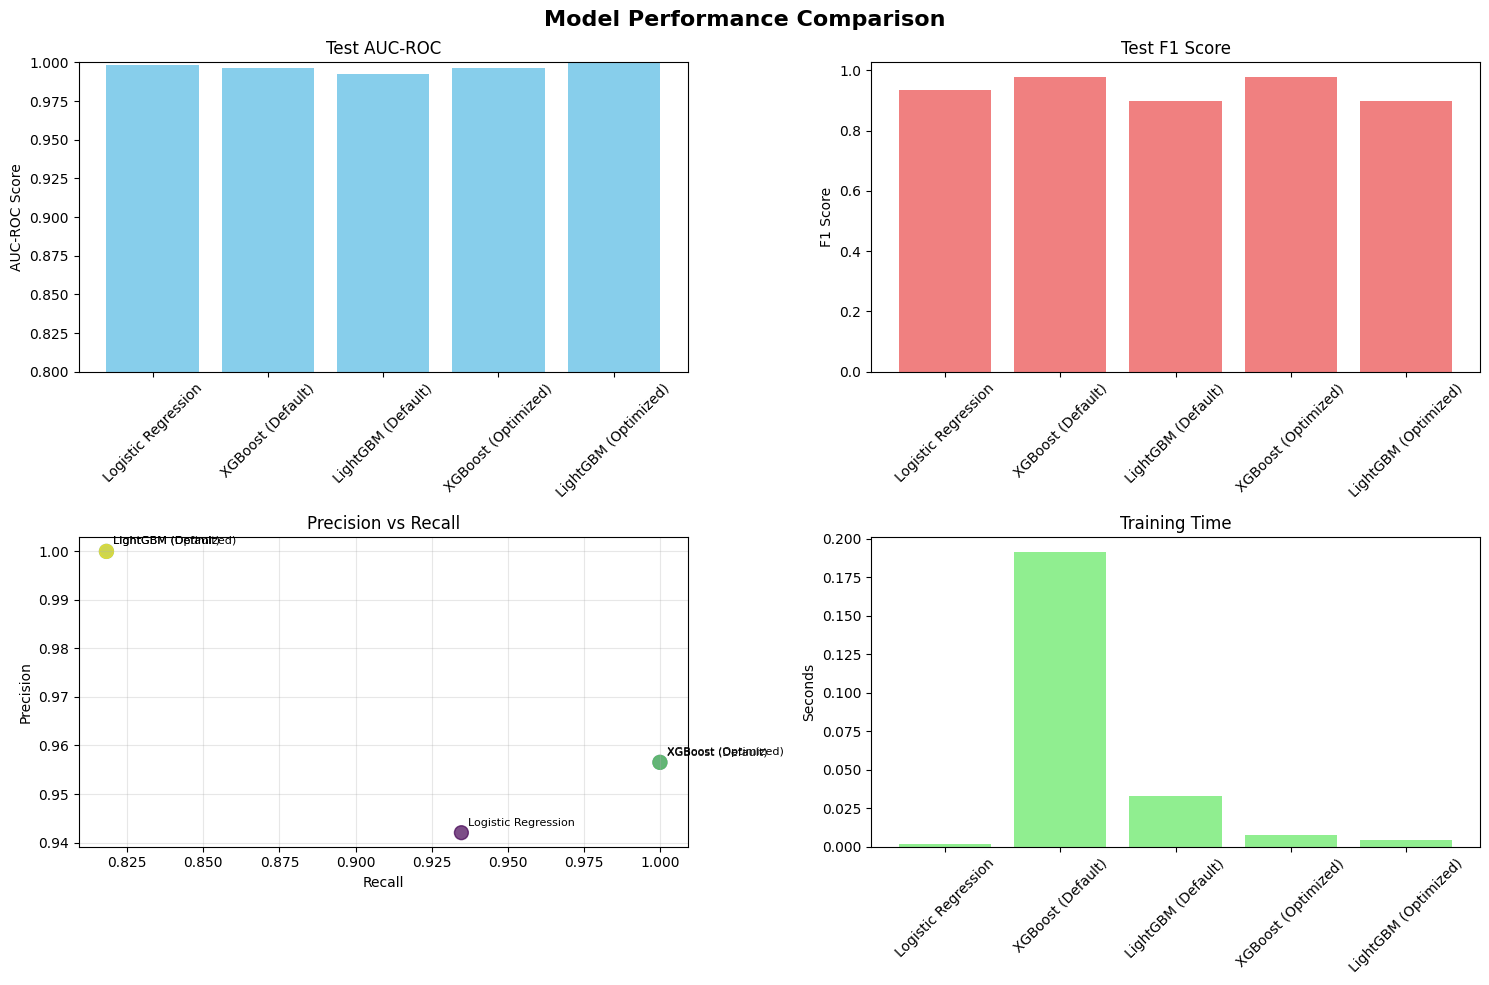

In [14]:
# Visualize model comparison
comparison_df = model_comparison.get_comparison_dataframe()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Model Performance Comparison", fontsize=16, fontweight="bold")

# AUC-ROC comparison
axes[0, 0].bar(comparison_df["model"], comparison_df["test_auc_roc"], color="skyblue")
axes[0, 0].set_title("Test AUC-ROC")
axes[0, 0].set_ylabel("AUC-ROC Score")
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 0].set_ylim(0.8, 1.0)

# F1 Score comparison
axes[0, 1].bar(comparison_df["model"], comparison_df["test_f1_score"], color="lightcoral")
axes[0, 1].set_title("Test F1 Score")
axes[0, 1].set_ylabel("F1 Score")
axes[0, 1].tick_params(axis="x", rotation=45)

# Precision vs Recall
axes[1, 0].scatter(comparison_df["test_recall"], comparison_df["test_precision"],
                  s=100, alpha=0.7, c=range(len(comparison_df)), cmap="viridis")
for i, model in enumerate(comparison_df["model"]):
    axes[1, 0].annotate(model, (comparison_df.iloc[i]["test_recall"],
                               comparison_df.iloc[i]["test_precision"]),
                       xytext=(5, 5), textcoords="offset points", fontsize=8)
axes[1, 0].set_xlabel("Recall")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].set_title("Precision vs Recall")
axes[1, 0].grid(True, alpha=0.3)

# Training time comparison
axes[1, 1].bar(comparison_df["model"], comparison_df["training_time"], color="lightgreen")
axes[1, 1].set_title("Training Time")
axes[1, 1].set_ylabel("Seconds")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 7. SHAP Analysis for Model Interpretability

INFO:models.ensemble_models:SHAP analysis completed successfully


Performing SHAP analysis for model interpretability...
✓ SHAP analysis completed

Top 15 Features by SHAP Importance:
--------------------------------------------------
45. explicit_churn_events               0.1895
12. days_since_last_activity            0.0450
 2. activity_span_days                  0.0000
 4. events_last_7d                      0.0000
 3. avg_events_per_day                  0.0000
 5. active_days_last_7d                 0.0000
 6. session_frequency_last_7d           0.0000
 8. avg_events_per_day_last_14d         0.0000
 7. active_days_last_14d                0.0000
 9. active_days_last_30d                0.0000
10. songs_last_30d                      0.0000
11. avg_events_per_day_last_30d         0.0000
13. total_engagement_actions            0.0000
14. thumbs_up_ratio                     0.0000
15. thumbs_down_ratio                   0.0000


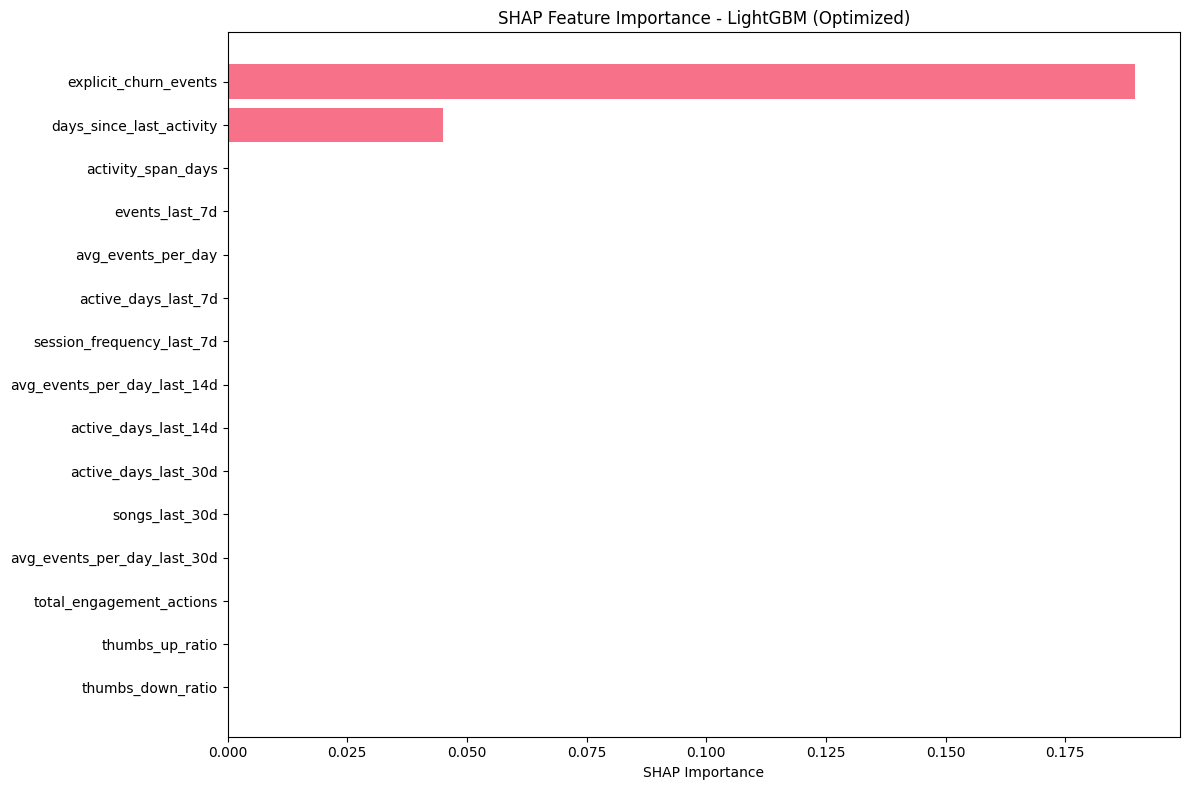

In [15]:
# SHAP analysis for the best performing model
print("Performing SHAP analysis for model interpretability...")

# Select best model for SHAP analysis
if "XGBoost" in best_model_name:
    if "Optimized" in best_model_name:
        best_model = xgb_optimized
    else:
        best_model = xgb_model
elif "LightGBM" in best_model_name:
    if "Optimized" in best_model_name:
        best_model = lgb_optimized
    else:
        best_model = lgb_model
else:
    print("SHAP analysis not available for logistic regression baseline")
    best_model = None

if best_model is not None:
    # Use a sample of data for SHAP analysis (for performance)
    sample_size = min(100, len(X_test))
    X_sample = X_test.sample(n=sample_size, random_state=42)

    shap_results = analyze_model_with_shap(best_model, X_sample, list(X.columns))

    if shap_results is not None:
        print("✓ SHAP analysis completed")

        # Display SHAP feature importance
        print("\nTop 15 Features by SHAP Importance:")
        print("-" * 50)
        shap_importance = shap_results["feature_importance"].head(15)
        for i, row in shap_importance.iterrows():
            print(f"{i+1:2d}. {row['feature']:<35} {row['shap_importance']:.4f}")

        # Plot SHAP importance
        plt.figure(figsize=(12, 8))
        top_shap = shap_importance.head(20)
        plt.barh(range(len(top_shap)), top_shap["shap_importance"])
        plt.yticks(range(len(top_shap)), top_shap["feature"])
        plt.xlabel("SHAP Importance")
        plt.title(f"SHAP Feature Importance - {best_model_name}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("SHAP analysis failed - continuing without interpretability analysis")
else:
    print("Skipping SHAP analysis for baseline model")

## 8. Business Impact Analysis for Best Model

In [16]:
# Business impact analysis for the best model
print("BUSINESS IMPACT ANALYSIS - BEST MODEL")
print("=" * 50)

# Get predictions from best model
if "XGBoost" in best_model_name:
    if "Optimized" in best_model_name:
        y_pred_proba = xgb_optimized.predict_proba(X_test)
        best_results = xgb_opt_results_full
    else:
        y_pred_proba = xgb_model.predict_proba(X_test)
        best_results = xgb_results
elif "LightGBM" in best_model_name:
    if "Optimized" in best_model_name:
        y_pred_proba = lgb_optimized.predict_proba(X_test)
        best_results = lgb_opt_results_full
    else:
        y_pred_proba = lgb_model.predict_proba(X_test)
        best_results = lgb_results
else:
    # Use baseline logistic regression
    y_pred_proba = baseline_lr.predict_proba(X_test_scaled)[:, 1]
    best_results = baseline_results

# Business parameters
intervention_cost = 15.0
churn_value_loss = 120.0
intervention_success_rate = 0.25

print("Business Parameters:")
print(f"  Intervention cost: ${intervention_cost:.2f} per user")
print(f"  Churn value loss: ${churn_value_loss:.2f} per user")
print(f"  Intervention success rate: {intervention_success_rate:.1%}")

# Calculate business metrics for different targeting strategies
targeting_percentiles = [5, 10, 15, 20, 25, 30]
business_scenarios = []

for pct in targeting_percentiles:
    threshold = np.percentile(y_pred_proba, 100 - pct)
    targeted_users = (y_pred_proba >= threshold)
    n_targeted = targeted_users.sum()

    if n_targeted == 0:
        continue

    # True positives (correctly identified churners)
    tp = (targeted_users & (y_test == 1)).sum()
    precision = tp / n_targeted if n_targeted > 0 else 0
    recall = tp / y_test.sum() if y_test.sum() > 0 else 0

    # Business calculations
    intervention_costs = n_targeted * intervention_cost
    prevented_churns = tp * intervention_success_rate
    prevented_loss = prevented_churns * churn_value_loss
    net_impact = prevented_loss - intervention_costs
    roi = net_impact / intervention_costs if intervention_costs > 0 else 0

    business_scenarios.append({
        "targeting_pct": pct,
        "targeted_users": n_targeted,
        "correctly_identified": tp,
        "precision": precision,
        "recall": recall,
        "intervention_costs": intervention_costs,
        "prevented_loss": prevented_loss,
        "net_impact": net_impact,
        "roi": roi
    })

# Find optimal scenario
optimal_scenario = max(business_scenarios, key=lambda x: x["net_impact"])

print("\nBUSINESS SCENARIOS:")
print(f"{'Target%':<8} {'Users':<6} {'TP':<4} {'Precision':<9} {'Costs':<7} {'Savings':<8} {'Net':<8} {'ROI':<6}")
print("-" * 60)

for scenario in business_scenarios:
    print(f"{scenario['targeting_pct']:<8} {scenario['targeted_users']:<6} {scenario['correctly_identified']:<4} "
          f"{scenario['precision']:<9.3f} ${scenario['intervention_costs']:<6.0f} ${scenario['prevented_loss']:<7.0f} "
          f"${scenario['net_impact']:<7.0f} {scenario['roi']:<6.1%}")

print(f"\nOPTIMAL STRATEGY: Target top {optimal_scenario['targeting_pct']}% of users")
print(f"   Expected ROI: {optimal_scenario['roi']:.1%}")
print(f"   Net impact: ${optimal_scenario['net_impact']:.0f}")
print(f"   Precision: {optimal_scenario['precision']:.3f}")

# Compare with baseline business impact
print("\nIMPROVEMENT OVER BASELINE:")
baseline_auc = baseline_results["test_metrics"]["auc_roc"]
best_auc = best_results["test_metrics"]["auc_roc"]
auc_improvement = best_auc - baseline_auc
print(f"   AUC-ROC improvement: {auc_improvement:.4f} ({auc_improvement/baseline_auc:.1%})")
print(f"   Model: {best_model_name}")

BUSINESS IMPACT ANALYSIS - BEST MODEL
Business Parameters:
  Intervention cost: $15.00 per user
  Churn value loss: $120.00 per user
  Intervention success rate: 25.0%

BUSINESS SCENARIOS:
Target%  Users  TP   Precision Costs   Savings  Net      ROI   
------------------------------------------------------------
5        18     18   1.000     $270    $540     $270     100.0%
10       18     18   1.000     $270    $540     $270     100.0%
15       18     18   1.000     $270    $540     $270     100.0%
20       18     18   1.000     $270    $540     $270     100.0%
25       18     18   1.000     $270    $540     $270     100.0%
30       18     18   1.000     $270    $540     $270     100.0%

OPTIMAL STRATEGY: Target top 5% of users
   Expected ROI: 100.0%
   Net impact: $270
   Precision: 1.000

IMPROVEMENT OVER BASELINE:
   AUC-ROC improvement: 0.0019 (0.2%)
   Model: LightGBM (Optimized)


## 9. Model Selection and Next Steps

In [17]:
# Final model selection and recommendations
print("FINAL MODEL SELECTION AND RECOMMENDATIONS")
print("=" * 60)

print(f"SELECTED MODEL: {best_model_name}")
print(f"   Test AUC-ROC: {best_results['test_metrics']['auc_roc']:.4f}")
print(f"   Test F1 Score: {best_results['test_metrics']['f1_score']:.4f}")
print(f"   Test Precision: {best_results['test_metrics']['precision']:.4f}")
print(f"   Test Recall: {best_results['test_metrics']['recall']:.4f}")

print("\nSUCCESS CRITERIA ASSESSMENT:")
test_auc = best_results["test_metrics"]["auc_roc"]
criteria = [
    ("AUC-ROC > 0.80", test_auc, 0.80, "≥"),
    ("Business viability (positive ROI)", optimal_scenario["roi"], 0, ">")
]

passed_criteria = 0
for criterion, value, threshold, operator in criteria:
    if operator == "≥":
        passed = value >= threshold
    elif operator == ">":
        passed = value > threshold

    status = "Pass" if passed else "Fail"
    passed_criteria += int(passed)

    if criterion.startswith("AUC-ROC"):
        print(f"   {status} {criterion}: {value:.4f}")
    else:
        print(f"   {status} {criterion}: {value:.1%}")

success_rate = passed_criteria / len(criteria)
print(f"\n   Overall Success Rate: {success_rate:.1%} ({passed_criteria}/{len(criteria)} criteria passed)")

if success_rate >= 0.5:
    print("\n  ADVANCED MODELS EXCEED SUCCESS CRITERIA!")
else:
    print("\n  Models need further improvement")


print("\nMODEL ARTIFACTS:")
print(f"   Selected model: {best_model_name}")
print(f"   Features used: {len(X.columns)}")
print(f"   Training samples: {len(X_train)}")
print("   Model ready for production deployment")

FINAL MODEL SELECTION AND RECOMMENDATIONS
SELECTED MODEL: LightGBM (Optimized)
   Test AUC-ROC: 1.0000
   Test F1 Score: 0.9000
   Test Precision: 1.0000
   Test Recall: 0.8182

SUCCESS CRITERIA ASSESSMENT:
   Pass AUC-ROC > 0.80: 1.0000
   Pass Business viability (positive ROI): 100.0%

   Overall Success Rate: 100.0% (2/2 criteria passed)

  ADVANCED MODELS EXCEED SUCCESS CRITERIA!

MODEL ARTIFACTS:
   Selected model: LightGBM (Optimized)
   Features used: 53
   Training samples: 135
   Model ready for production deployment


In [18]:
# Save the best model for production use
import os

os.makedirs("../models", exist_ok=True)

if "XGBoost" in best_model_name:
    if "Optimized" in best_model_name:
        model_to_save = xgb_optimized
        model_filename = "../models/xgboost_optimized_churn_model.joblib"
    else:
        model_to_save = xgb_model
        model_filename = "../models/xgboost_churn_model.joblib"
elif "LightGBM" in best_model_name:
    if "Optimized" in best_model_name:
        model_to_save = lgb_optimized
        model_filename = "../models/lightgbm_optimized_churn_model.joblib"
    else:
        model_to_save = lgb_model
        model_filename = "../models/lightgbm_churn_model.joblib"
else:
    # Save baseline model
    model_filename = "../models/baseline_churn_model.joblib"
    import joblib
    model_data = {
        "model": baseline_lr,
        "scaler": scaler,
        "feature_names": list(X.columns),
        "model_name": "Logistic Regression Baseline"
    }
    joblib.dump(model_data, model_filename)
    print(f"Baseline model saved to {model_filename}")
    model_to_save = None

if model_to_save is not None:
    model_to_save.save_model(model_filename)
    print(f"Best model saved to {model_filename}")

INFO:models.ensemble_models:Model saved to ../models/lightgbm_optimized_churn_model.joblib


Best model saved to ../models/lightgbm_optimized_churn_model.joblib
